<a href="https://colab.research.google.com/github/IPL-UV/gaussflow/blob/master/docs/assets/demo/pytorch_nf_freia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Freia - Coupling Transforms

This is my notebook where I play around with all things PyTorch. I use the following packages:

* PyTorch
* Pyro
* GPyTorch
* PyTorch Lightning


In [1]:
# @title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(root))
except ModuleNotFoundError:
    import os

    !pip install --upgrade pyro-ppl gpytorch pytorch-lightning tqdm wandb corner nflows
    !pip install git+https://github.com/VLL-HD/FrEIA.git

In [2]:
#@title Load Packages
# TYPE HINTS
from typing import Tuple, Optional, Dict, Callable, Union

# PyTorch Settings
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.distributions as dist

# PyTorch Lightning Settings
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.loggers import WandbLogger

# NUMPY SETTINGS
import numpy as np
np.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import corner
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import ml_collections
import wandb

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Using device: {}".format(device))
#logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2

/home/emmanuel/.conda/envs/gaussflow-gpu/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


Using device: cpu


## Logging

In [80]:
cfg = ml_collections.ConfigDict()

# Logger
cfg.wandb_project = "gf2_0"
cfg.wandb_entity = "ipl_uv"
cfg.batch_size = 256
cfg.num_workers = 8
cfg.seed = 123

# Data
cfg.n_train = 5_000
cfg.n_valid = 1_000
cfg.n_test = 2_000
cfg.noise = 0.05

# Model
cfg.loss_fn = "inn"
cfg.n_layers = 2
cfg.n_features = 2
cfg.n_reflections = 2
cfg.coupling = "rqs"

# Training
cfg.num_epochs = 100
cfg.learning_rate = 1e-3
cfg.n_total_steps = cfg.num_epochs * cfg.n_train

In [81]:
seed_everything(cfg.seed)

Global seed set to 123


123

In [82]:
# wandb_logger = WandbLogger(project=cfg.wandb_project, entity=cfg.wandb_entity)
# wandb_logger.experiment.config.update(cfg)


## Data

In [83]:
from sklearn.datasets import make_moons

data, label = make_moons(n_samples=cfg.n_train, noise=cfg.noise)

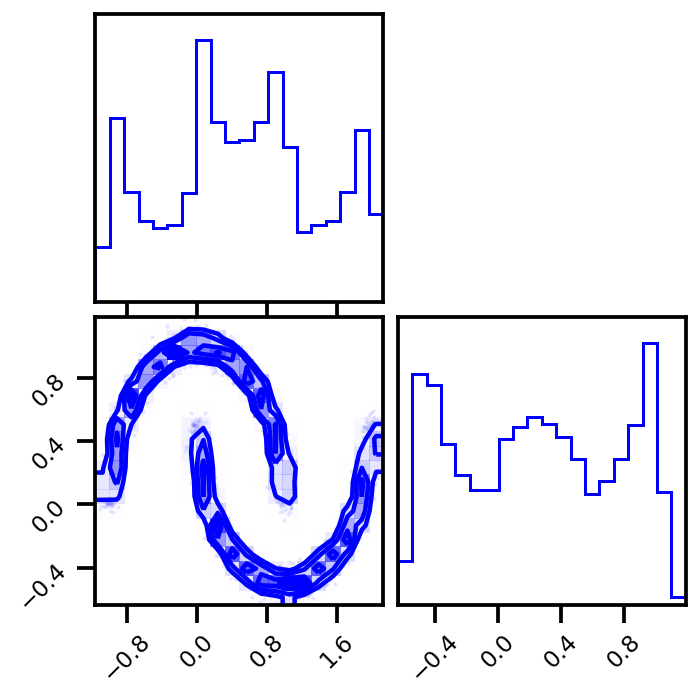

In [84]:
fig = corner.corner(data, hist_factor=2, color="blue")

#### DataLoader

In [85]:

data_train, label = make_moons(n_samples=cfg.n_train, noise=cfg.noise, random_state=123)
data_valid, label = make_moons(n_samples=cfg.n_valid, noise=cfg.noise, random_state=42)
X_train = torch.FloatTensor(data_train)
X_valid = torch.FloatTensor(data_valid)

# make into dataset
train_ds = TensorDataset(X_train)
valid_ds = TensorDataset(X_valid)

# make dataloader
shuffle = True

train_dl = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=shuffle, num_workers=cfg.num_workers)
valid_dl = DataLoader(valid_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

In [86]:
def tensor2numpy(x):
    return x.detach().cpu().numpy()
def numpy2tensor(x):
    return torch.Tensor(x)

## Model

### Lightning Module

In [87]:
from src.lit_plane import FlowLearnerPlane

### Standard RVP

In [88]:
from nflows.utils import create_alternating_binary_mask
from nflows.nn.nets import ResidualNet

In [89]:
import torch.nn.functional as F

class MultiHeadMLP(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers, K):
        super().__init__()

        self.K = K

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))

        self.dense_a = nn.Linear(nh,d_out)
        self.dense_b = nn.Linear(nh,d_out)
        self.dense_pi = nn.Linear(nh,d_out*K)
        self.dense_mu = nn.Linear(nh,d_out*K)
        self.dense_s = nn.Linear(nh,d_out*K)
        
        self.act = nn.LeakyReLU(0.2)


    def forward(self, x):
        for layer in self.layers:
            x = self.act(layer(x))

        a = self.dense_a(x)
        b = self.dense_b(x)
        pi = self.dense_pi(x)
        mu = self.dense_mu(x)
        s = self.dense_s(x)
        
        return torch.cat([a, b, pi, mu, s], dim=1)

#         return a, b, pi, mu, s
n_components = 8
def multihead_fc(dims_in, dims_out):
    return MultiHeadMLP(dims_in, 32, dims_out, 2, K=n_components)

In [90]:
# t = multihead_fc()

In [91]:
import torch.functional as F
from src.models.nets.dense import MLP

def nflows_fc(dims_in, dims_out):
    return  MLP(dims_in, dims_out, hidden_features=[512, 512], activation=nn.ReLU())
def nflows_resnet(dims_in, dims_out):
    return ResidualNet(dims_in, dims_out, hidden_features=512, num_blocks=1, activation=nn.ReLU())

In [92]:
# from nflows.transforms import PiecewiseRationalQuadraticCouplingTransform

# mask = create_alternating_binary_mask(features=cfg.n_features, even=(0 % 2 == 0))

# rsq_coupling_layer = PiecewiseRationalQuadraticCouplingTransform(
#             mask=mask,
#             transform_net_create_fn=multihead_fc,
#             num_bins=8,
#             tails="linear",
#             tail_bound=5,
#         )

# z, ldj = rsq_coupling_layer(numpy2tensor(data))

In [96]:
# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm
from src.models.layers.coupling import get_coupling_layer



# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(2)

for ilayer in range(2):
# for ilayer in range(1):
    
    # coupling transform (GLOW)
#     coupling_transform = get_coupling_layer(coupling="flowpp")
#     inn.append(
#         coupling_transform, 
#         subnet_constructor=nflows_resnet,
#         inv_eps=1e-5,
#         n_components=n_components
#     )
    
    
    # create coupling transform
    coupling_transform = get_coupling_layer(coupling="rqs")
    mask = create_alternating_binary_mask(features=cfg.n_features, even=(ilayer % 2 == 0))
    inn.append(
        coupling_transform, 
        subnet_constructor=nflows_resnet,
        mask=mask,
        tails="linear",
        tail_bound=5,
        apply_unconditional_transform=False
    )
    
    # orthogonal transformation
#     inn.append(Fm.HouseholderPerm, n_reflections=cfg.n_reflections)

base_dist = dist.Normal(torch.tensor([0.0]), torch.tensor([1.0]))

#### Initial Transformation

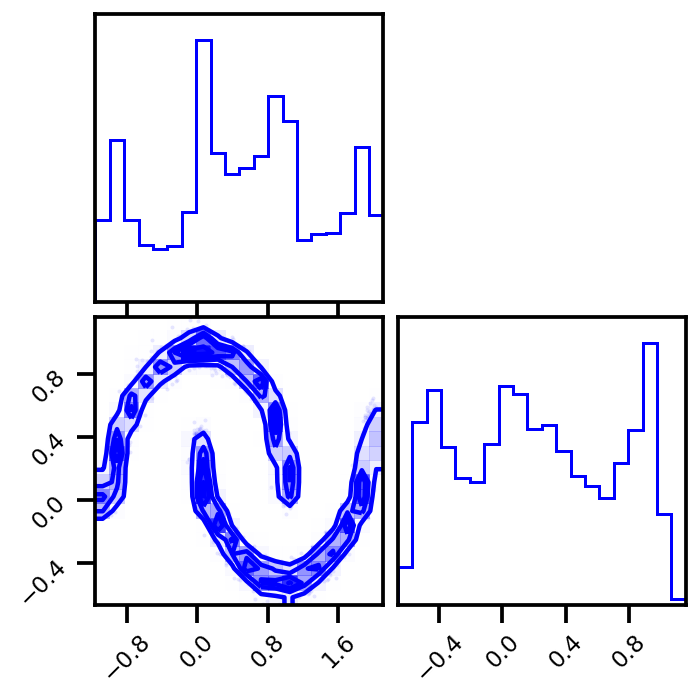

In [97]:
x = torch.Tensor(data)
z, log_jac_det = inn(x)

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="blue")

## Training

In [ ]:
learn = FlowLearnerPlane(inn,  base_dist, cfg)
trainer = pl.Trainer(
    # epochs
    min_epochs=5, 
    max_epochs=100, #cfg.num_epochs, 
    # progress bar
    progress_bar_refresh_rate=100, 
    # device
    gpus=0,
    # gradient norm
    gradient_clip_val=5.0, 
    gradient_clip_algorithm='norm', 
#     logger=wandb_logger
)
trainer.fit(learn, train_dataloader=train_dl, val_dataloaders=valid_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Set SLURM handle signals.

  | Name  | Type        | Params
--------------------------------------
0 | model | SequenceINN | 1.1 M 
--------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.330     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 123


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

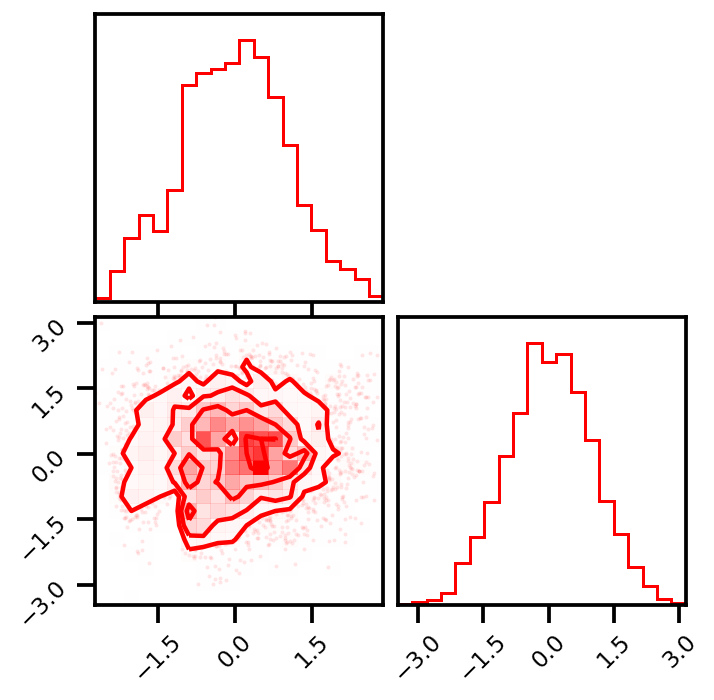

In [42]:
z, log_jac_det = learn.model(X_train)

fig = corner.corner(z.detach().numpy(), hist_factor=2, color="red")
# wandb_logger.experiment.log({"latent_trained": wandb.Image(fig)})

#### Inverse Transform

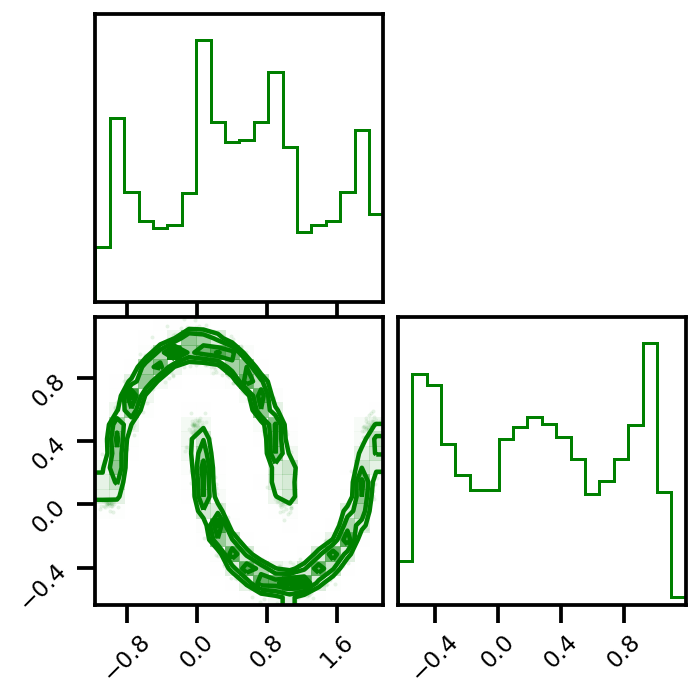

In [43]:
x_ori, _ = learn.model(z, rev=True)

fig = corner.corner(x_ori.detach().numpy(), hist_factor=2, color="green")
# wandb_logger.experiment.log({"latent_trained_inv": wandb.Image(fig)})

#### Density Estimation

In [44]:
from src.viz.bivariate import generate_2d_grid

# Read data
X_plot, _ = make_moons(n_samples=100_000, shuffle=True, noise=0.05, random_state=123 + 2)

# # sampled data
data_plot, label = make_moons(n_samples=100, noise=0.05)
xyinput = generate_2d_grid(data_plot, 500, buffer=0.1)

In [45]:
z, log_jac_det = learn.model(torch.Tensor(xyinput))

X_log_prob = base_dist.log_prob(z).sum(1) + log_jac_det
X_log_prob = X_log_prob.detach().numpy()

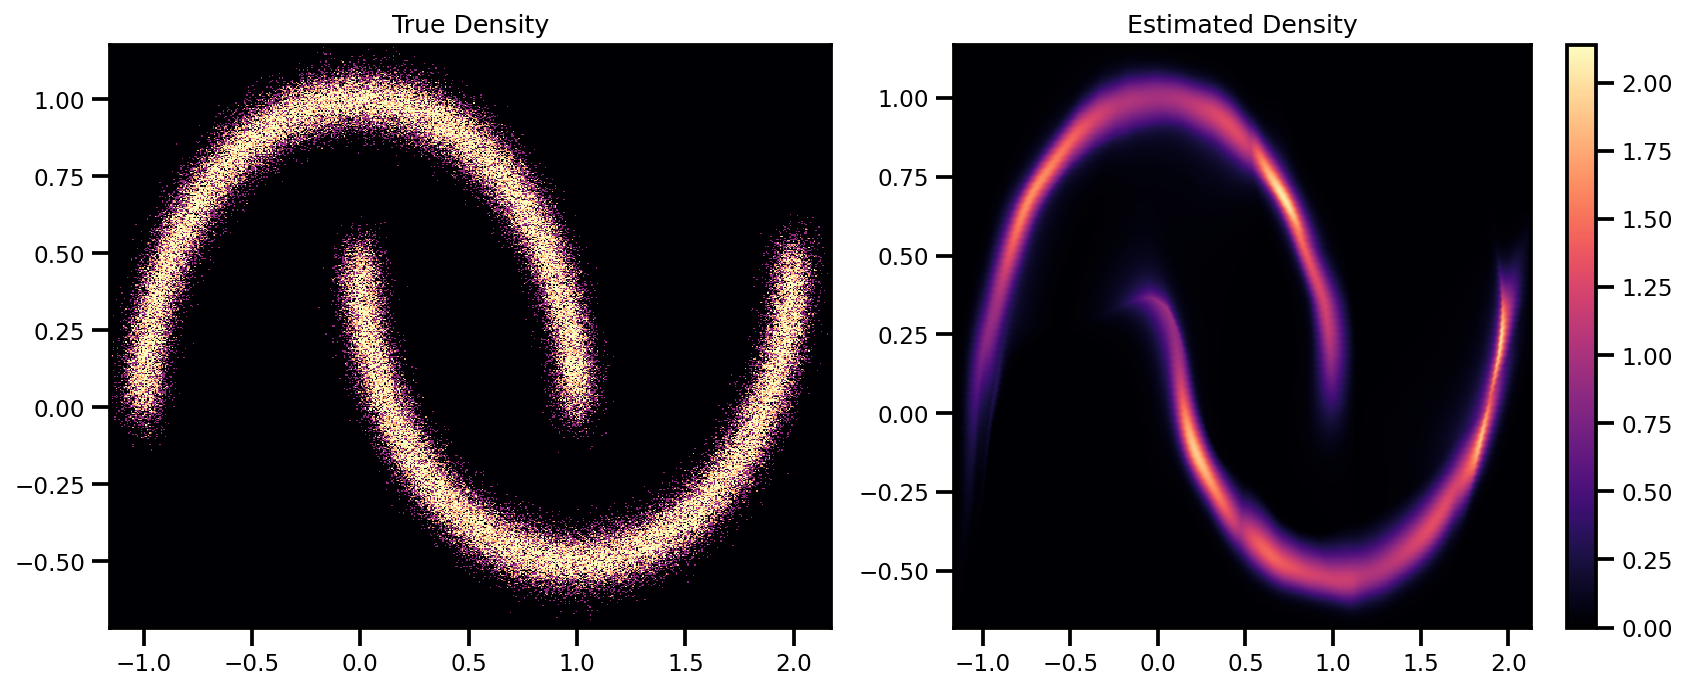

In [46]:
from matplotlib import cm

# # Original Density
# n_samples = 1_000_000
# n_features = 2
# X_plot = load_data(n_samples, 42)
# X_plot = StandardScaler().fit_transform(X_plot)

# Estimated Density
cmap = cm.magma  # "Reds"
probs = np.exp(X_log_prob)
# probs = np.clip(probs, 0.0, 1.0)
# probs = np.clip(probs, None, 0.0)


cmap = cm.magma  # "Reds"
# cmap = "Reds"

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
h = ax[0].hist2d(
    X_plot[:, 0], X_plot[:, 1], bins=512, cmap=cmap, density=True, vmin=0.0, vmax=1.0
)
ax[0].set_title("True Density")
ax[0].set(
    xlim=[X_plot[:, 0].min(), X_plot[:, 0].max()],
    ylim=[X_plot[:, 1].min(), X_plot[:, 1].max()],
)


h1 = ax[1].scatter(
    xyinput[:, 0], xyinput[:, 1], s=1, c=probs, cmap=cmap, vmin=0.0, #vmax=1.0
)
ax[1].set(
    xlim=[xyinput[:, 0].min(), xyinput[:, 0].max()],
    ylim=[xyinput[:, 1].min(), xyinput[:, 1].max()],
)
plt.colorbar(h1)
ax[1].set_title("Estimated Density")


plt.tight_layout()
plt.show()
# wandb_logger.experiment.log({"density": wandb.Image(fig)})

#### Sampling

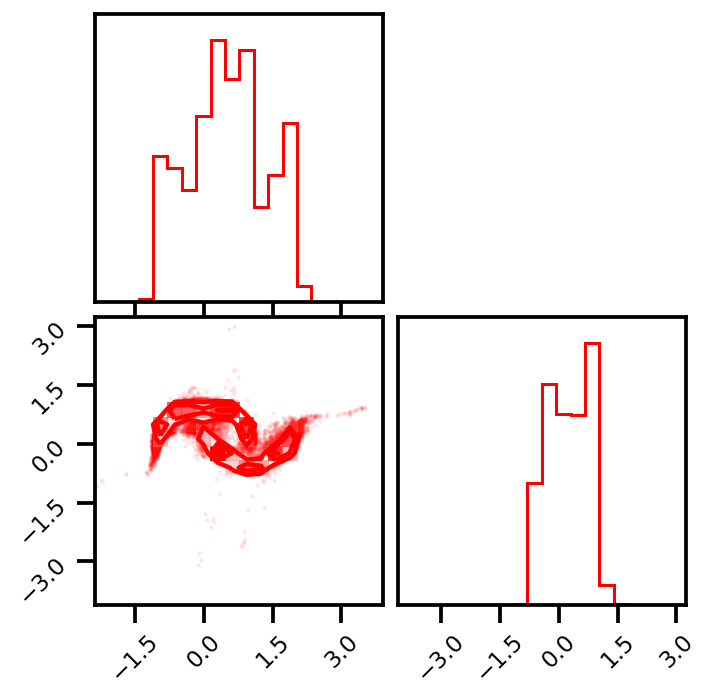

In [47]:
# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
n_samples = 100_000
z = torch.randn(n_samples, cfg.n_features)
samples, _ = learn.model(z, rev=True)

fig = corner.corner(samples.detach().numpy(), hist_factor=2, color="red")
# wandb_logger.experiment.log({"sampling_trained": wandb.Image(fig)})